#Install libraries

In [1]:
# Uncomment to install phasorpy and ptufile
print("Installing necessary libraries...")
!pip install phasorpy > /dev/null 2>&1
!pip install ptufile > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load libraries

In [3]:
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_ptu
from phasorpy.plot import plot_signal_image, plot_phasor_image, PhasorPlot

from phasorpy.phasor import phasor_from_signal, phasor_threshold
from phasorpy.phasor import (
    lifetime_to_signal,
    phasor_calibrate,
    phasor_from_lifetime,
    phasor_from_signal,
)

import numpy as np

ImportError: cannot import name 'lifetime_to_signal' from 'phasorpy.phasor' (/usr/local/lib/python3.12/dist-packages/phasorpy/phasor.py)

## Load data

In [ ]:
#img_data = '/content/drive/MyDrive/2025/Articulos/MSSR-FLIM/Codes/Series043_CONFOCAL.ptu'
img_data = fetch('hazelnut_FLIM_single_image.ptu'). ## This is sample data
signal = signal_from_ptu(img_data)
frequency = signal.attrs['frequency']

### Uncoment to analyze a single experiment
#signal = signal[0, :, :, 0]


#####  Uncoment to average four replicates
mean_signal = np.mean(signal, axis=0)  # Shape: (512, 512, 1, 132)
signal = np.squeeze(mean_signal, axis=2)

#### Uncoment to remove IRF
#signal = signal[:,:,1:74]

SyntaxError: invalid syntax (<ipython-input-4-e94ea0c161af>, line 2)

## Explore the data

In [ ]:
#print("Signal Values:\n", signal.values)
print("\nSignal Data Type:", signal.dtype)
print("\nSignal Shape:", signal.shape)
print("\nSignal Dimensions:", signal.dims)
print("\nSignal 'H' Coordinates Data:\n", signal.coords['H'].data)
#print("\nSignal Frequency Attribute:", signal.attrs['frequency'])

In [ ]:

plot_signal_image(signal, axis='H')

In [ ]:
mean, real, imag = phasor_from_signal(signal, axis='H')

In [ ]:
plot_phasor_image(mean, real, imag, title='Sample')

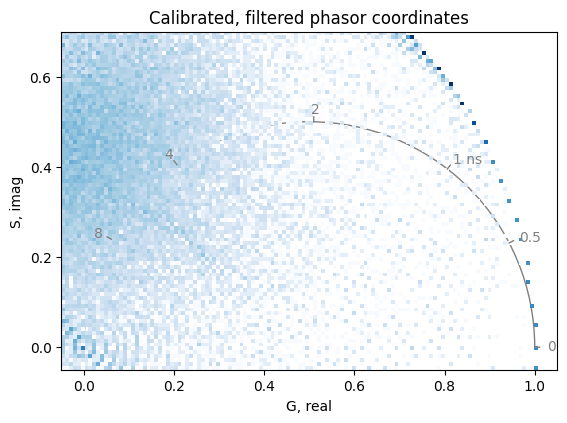

In [ ]:
phasorplot = PhasorPlot(
    frequency=frequency, title='Calibrated, filtered phasor coordinates'
)
phasorplot.hist2d(real, imag)
phasorplot.show()

## Synthesize a TD-FLIM reference signal, taking as an example a homogeneous solution of fluorescein with a lifetime of 4.2 ns.

In [ ]:
settings = {
    'samples': signal.shape[2],  # number of samples to synthesize
    'mean': np.mean(signal),  # average intensity
    'background': np.min(signal),  # no signal from background
    'zero_phase': None,  # location of IRF peak in the phase
    'zero_stdev': None,  # standard deviation of IRF in radians
}
reference_lifetime = 2
color = 'PRGn' #'cmc.batlowK'


In [ ]:
reference_signal, _, _ = lifetime_to_signal(frequency, reference_lifetime, **settings)
img_reference_signal = np.zeros(signal.shape)

for x in range(img_reference_signal.shape[0]):  # Loop over x-dimension
    for y in range(img_reference_signal.shape[1]):  # Loop over y-dimension
        img_reference_signal[x, y, :] = reference_signal  # Assign time-domain signal

#assert reference_signal.attrs['frequency'] == frequency
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)

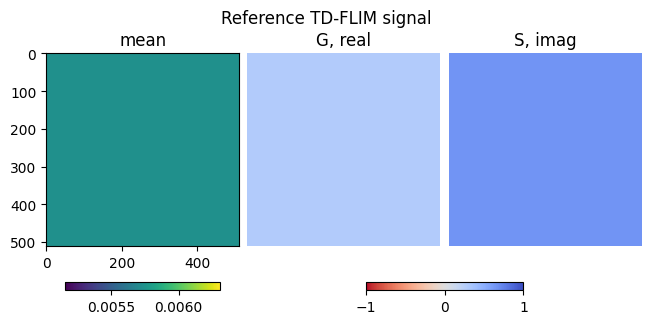

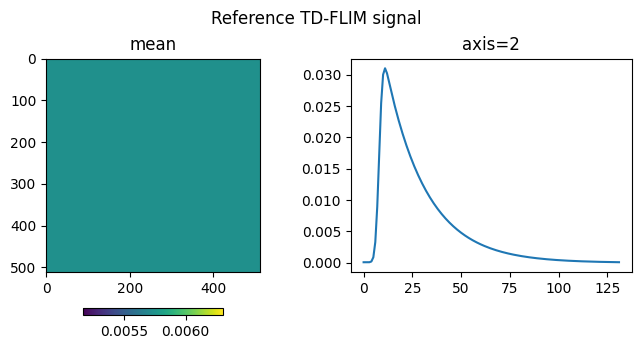

In [ ]:
plot_phasor_image(
    img_reference_mean, img_reference_real, img_reference_imag, title='Reference TD-FLIM signal'
)

plot_signal_image(img_reference_signal, title='Reference TD-FLIM signal')

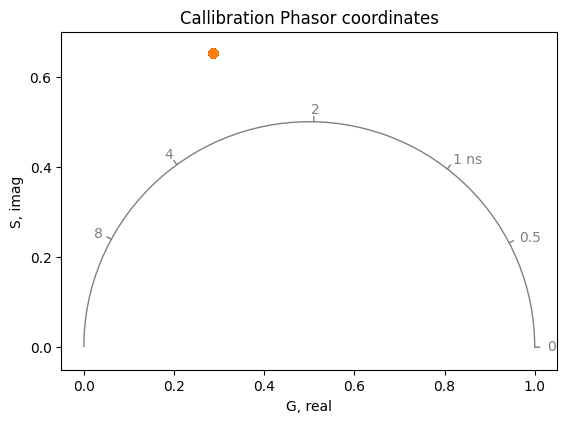

In [ ]:
# Plot calibration phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Callibration Phasor coordinates')
  plot.plot(img_reference_real, img_reference_imag)
  plot.show()

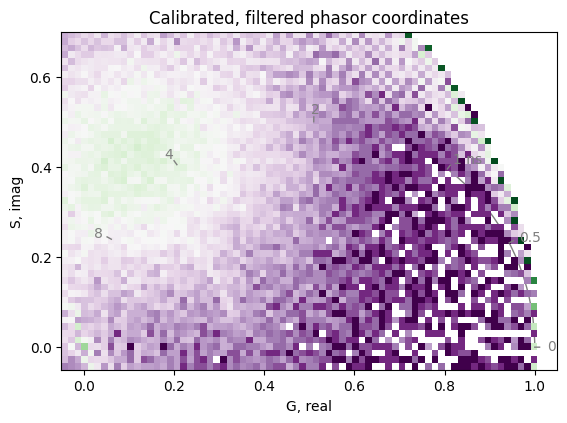

In [ ]:

# Calibrate phasor coordinates using reference
real_cal, imag_cal = phasor_calibrate(real, imag, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_cal, imag_cal, bins = 75, cmap=color)


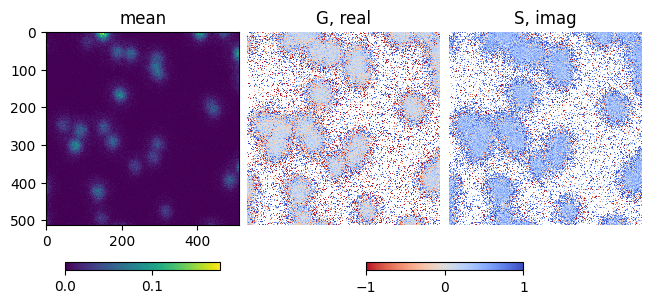

In [ ]:
plot_phasor_image(mean, real_cal, imag_cal)

## Filter and threshold

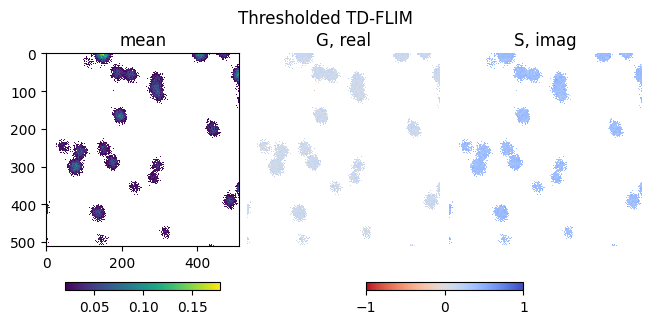

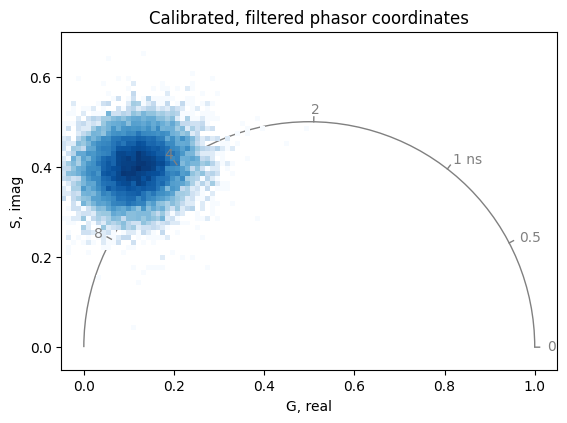

In [ ]:
from phasorpy.phasor import phasor_filter_median
mean_mf, real_mf, imag_mf = phasor_filter_median(mean, real_cal, imag_cal, size=3, repeat=2)

mean_th, real_th, imag_th = phasor_threshold(mean_mf, real_mf, imag_mf, mean_min=0.02)
plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th, imag_th, bins = 100)